# Hybrid CART

# Imports

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator
from utils.master_generator import MasterGenerator


import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-22 07:38:25.608042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 07:38:25.721681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734849505.767928    5492 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734849505.781523    5492 cuda_blas.cc:1418] Un

Load hybrids cars

In [2]:
data = Loader.load_by_fueltype("Híbrido")
label_encoder = LabelEncoder()

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

In [3]:
data["price_categ"].value_counts()

price_categ
Middle low range     6780
Middle range         3700
Middle high range    2364
Premiun              2137
Luxury               1829
High end             1766
Budget               1367
Low end               147
Very low end            9
Name: count, dtype: int64

This result is telling us that in the world of hybrid cars is much common to have a high price car than a low end hybrid car. So as we can see that our dataset is not perfectly balanced so we are going to studie and transform this data to make it more tratable for the clasificattion algorithms

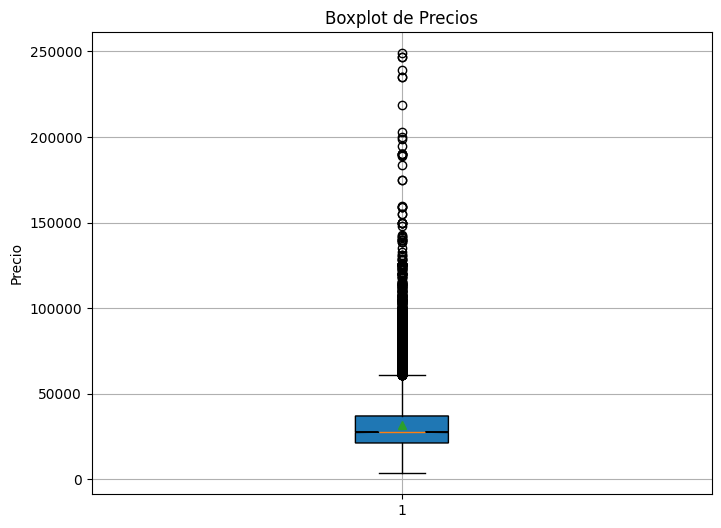

In [4]:
precios_hibridos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_hibridos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [5]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Híbrido"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

60663.75


,price,brand
idx,,
1412,248900,LAND-ROVER
130244,246743,LAND-ROVER
129813,246743,LAND-ROVER
12846,239000,LAND-ROVER
34280,234900,LAND-ROVER
...,...,...
32009,60900,MERCEDES-BENZ
123032,60900,AUDI
123654,60900,VOLVO


# PCA and correlation matrix

In [6]:
def fill_hybrid_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_hybrid_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_hybrid_numerical_columns(numerical_columns)


In [7]:
numerical_columns = get_hybrid_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.1921738848688999%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 13.021414929074568%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 7.807865383114107%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.150602004390307%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.8421502437153325%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 20.647155838330733%


In [8]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.159676
year                     0.314151
cubicCapacity            0.577080
doors                    0.041913
seatingCapacity          0.234695
trunkCapacityInLiters    0.431428
maxSpeed                 0.580215
acceleration            -0.605923
power_cv                 0.756233
power_kw                 0.756358
max_torque_nm            0.762390
speakers                 0.369709
dimensions.width         0.645872
dimensions.height        0.344293
dimensions.length        0.606820
Numero_Testigos          0.097956
displacement_liters      0.575881
displacement_cc         -0.318374
number_of_cylinders      0.562774
compression_ratio       -0.249466
Llantas_Diametro_cm      0.627018
Name: price, dtype: float64


In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

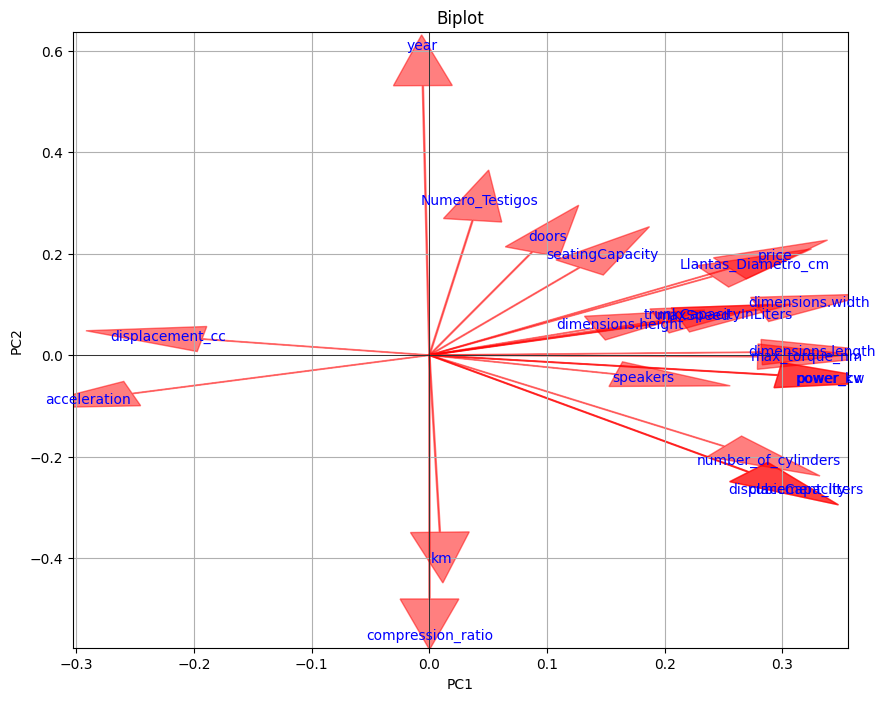

In [10]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

### Test Tree regressor

In [11]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 1992.8282667912886 
 MSE: 16124997.746206151 
 RMSE: 4015.5943204220907 
 R2: 0.9458390146157255 
 MAPE: 6.215593967881832
Mean: 1992.8282667912886
Variance: 12153633.245283779
Standard Deviation: 3486.206139241307


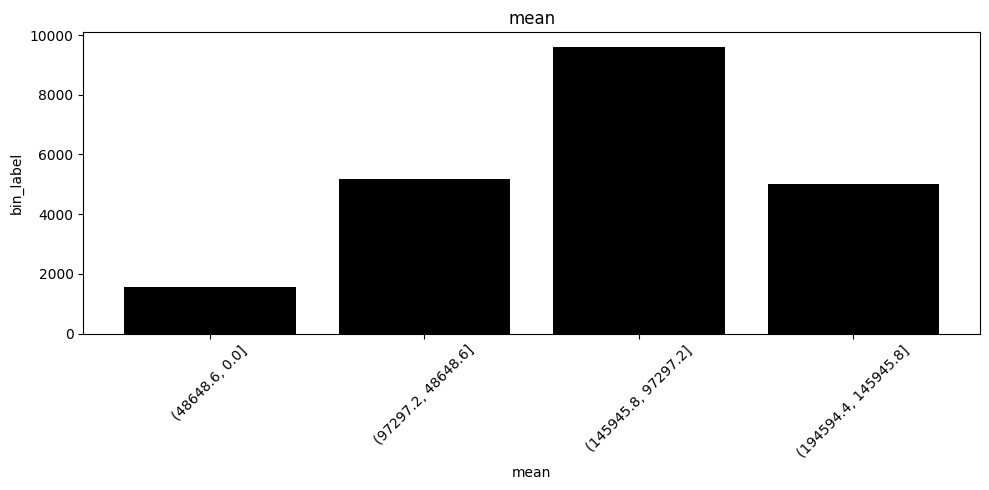

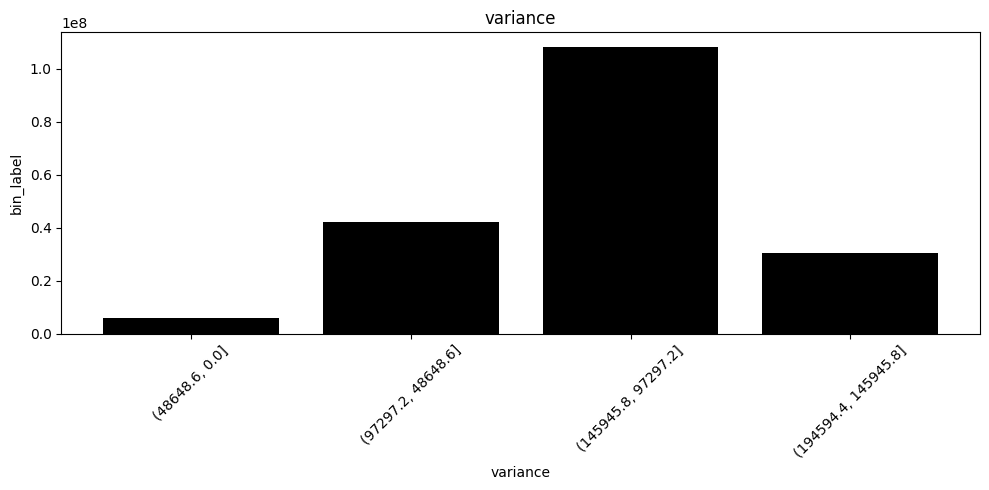

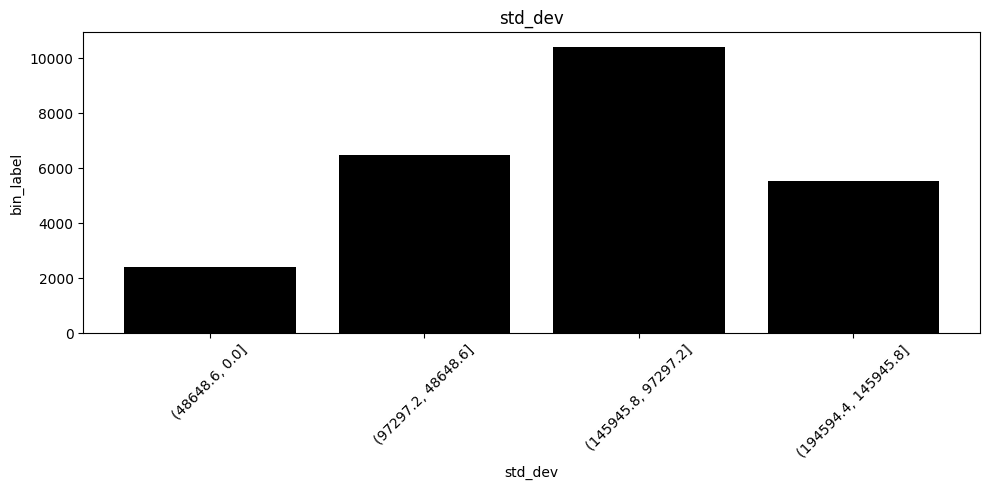

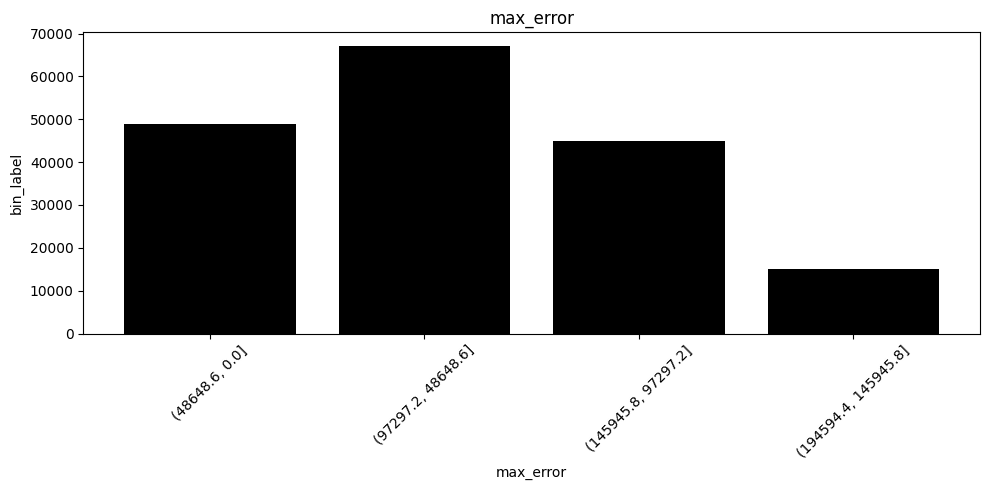

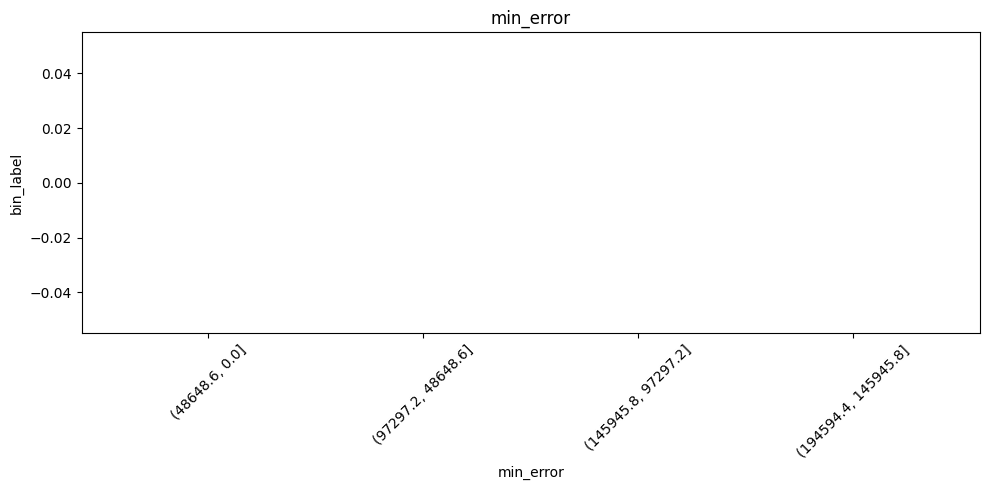

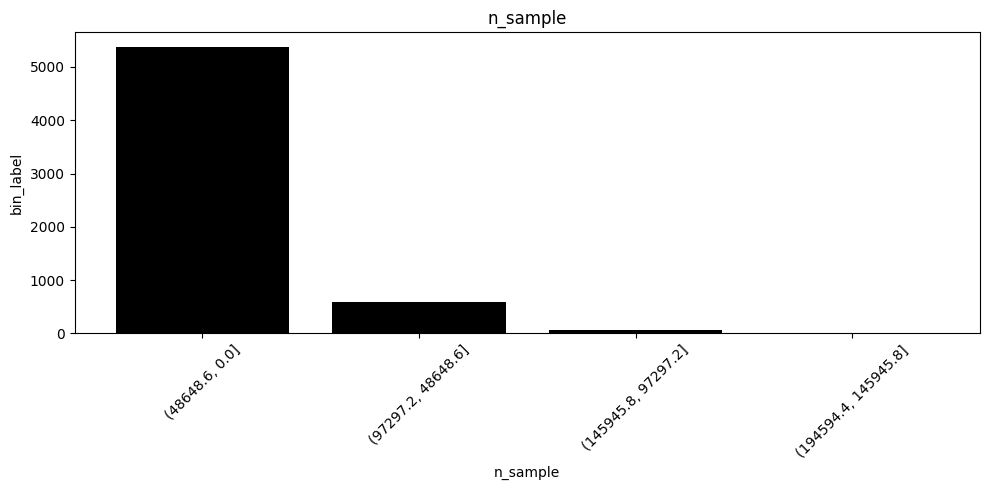

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(48648.6, 0.0]",1559.281015,5.830855e+06,2414.716275,49000.0,0.0,5381
1,"(97297.2, 48648.6]",5172.866331,4.219151e+07,6495.499122,66990.0,0.0,580
2,"(145945.8, 97297.2]",9612.836022,1.084146e+08,10412.231241,44905.0,0.0,62
3,"(194594.4, 145945.8]",5000.833333,3.046317e+07,5519.345082,15000.0,0.0,6


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

In [13]:
def get_hybrid_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    data['price_categ'] = data['price_categ'].astype('category')

    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_hybrid_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df

# convert object columns to category
data = category_convert(data)

categorical_columns = get_hybrid_categorical_columns(data)

categorical_columns = fill_hybrid_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#print("Columnas en categorical_columns:", categorical_columns.columns)


Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 0
Number of missing values in 'environmentalLabel' before filling with 'unknown': 1
Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [14]:

# Obtener la distribución con los nombres de categoría
distribution = categorical_columns["price_categ"].value_counts()
print(distribution)


price_categ
Middle low range     6780
Middle range         3700
Middle high range    2364
Premiun              2137
Luxury               1829
High end             1766
Budget               1367
Low end               147
Very low end            9
Name: count, dtype: int64


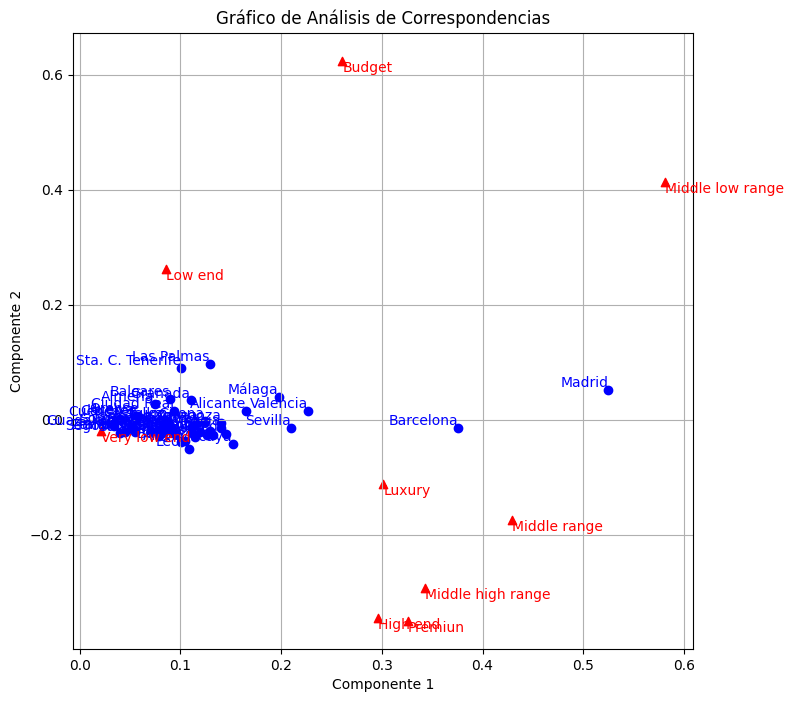

In [15]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

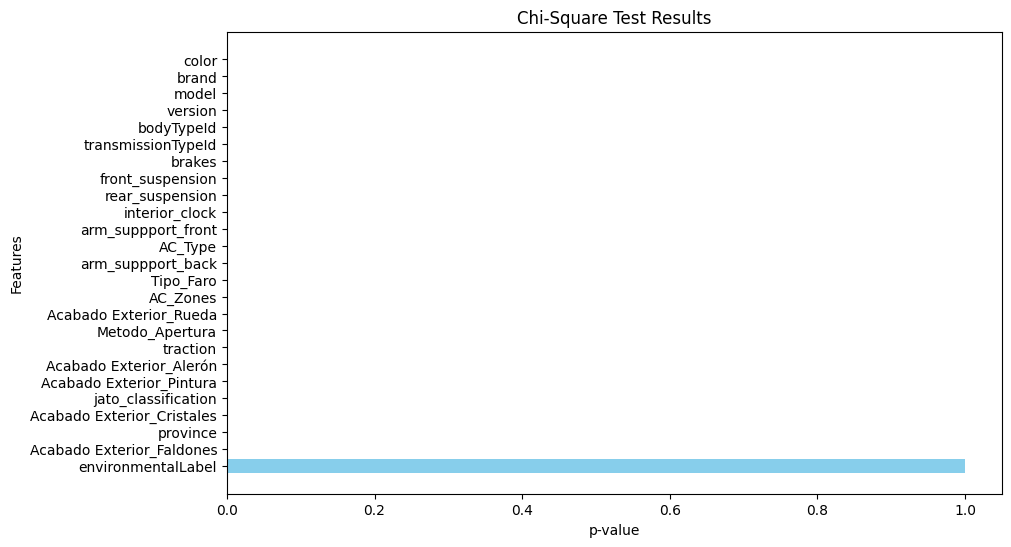

,Feature,Chi2 Stat,p-value
0,color,6.904929e+04,0.000000e+00
1,brand,6.670518e+03,0.000000e+00
2,model,4.519651e+04,0.000000e+00
3,version,1.244725e+06,0.000000e+00
4,bodyTypeId,9.020079e+03,0.000000e+00
5,transmissionTypeId,3.210345e+03,0.000000e+00
10,brakes,5.274799e+03,0.000000e+00
11,front_suspension,2.101354e+03,0.000000e+00
12,rear_suspension,7.840275e+03,0.000000e+00
22,interior_clock,1.627225e+03,0.000000e+00


In [16]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

# Categorical CART

In [17]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)


In [18]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
81276,Middle range,Middle range,0
121948,Budget,Middle range,1
98497,Budget,Budget,0
68753,Budget,Budget,0
707,Budget,High end,3
...,...,...,...
105115,Middle range,Middle range,0
154437,High end,High end,0
104917,Budget,Budget,0


In [19]:
# Calcular la precisión
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7530679933665009 
 Precision: 0.7514213690228273 
 Recall: 0.7530679933665009 
 F1 Score: 0.751747097320804
Confusion Matrix:
 [[1708    7    3    1   28   62  161    3    2]
 [   7  355    0    8   85    1   19   69    0]
 [   3    0   25    0    0   16    1    0    0]
 [   2    6    0  485    6    0    1   58    0]
 [  31   78    2    8  440    1  121   16    0]
 [  81    0   16    0    0  321    2    1    0]
 [ 239   29    0    2  100    1  760    7    0]
 [   4   91    0   77   23    1    7  446    0]
 [   1    0    1    0    0    0    0    0    1]]


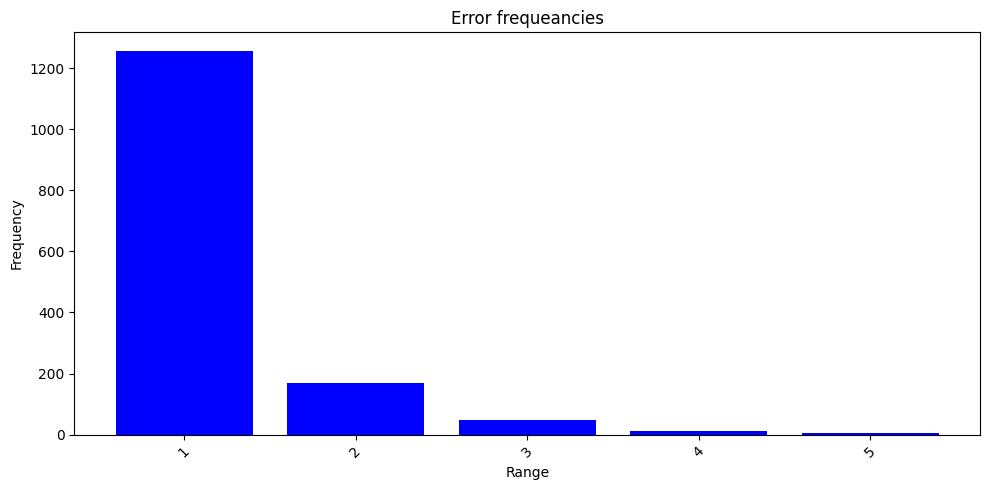

{1: 1255, 2: 169, 3: 47, 4: 13, 5: 5}
Error mean: 1.216252518468771
Error rate: 24.693200663349916 %
Overall mean: 0.30033167495854063


In [20]:
Evaluator.eval_ordinal_classification (result["diff"])

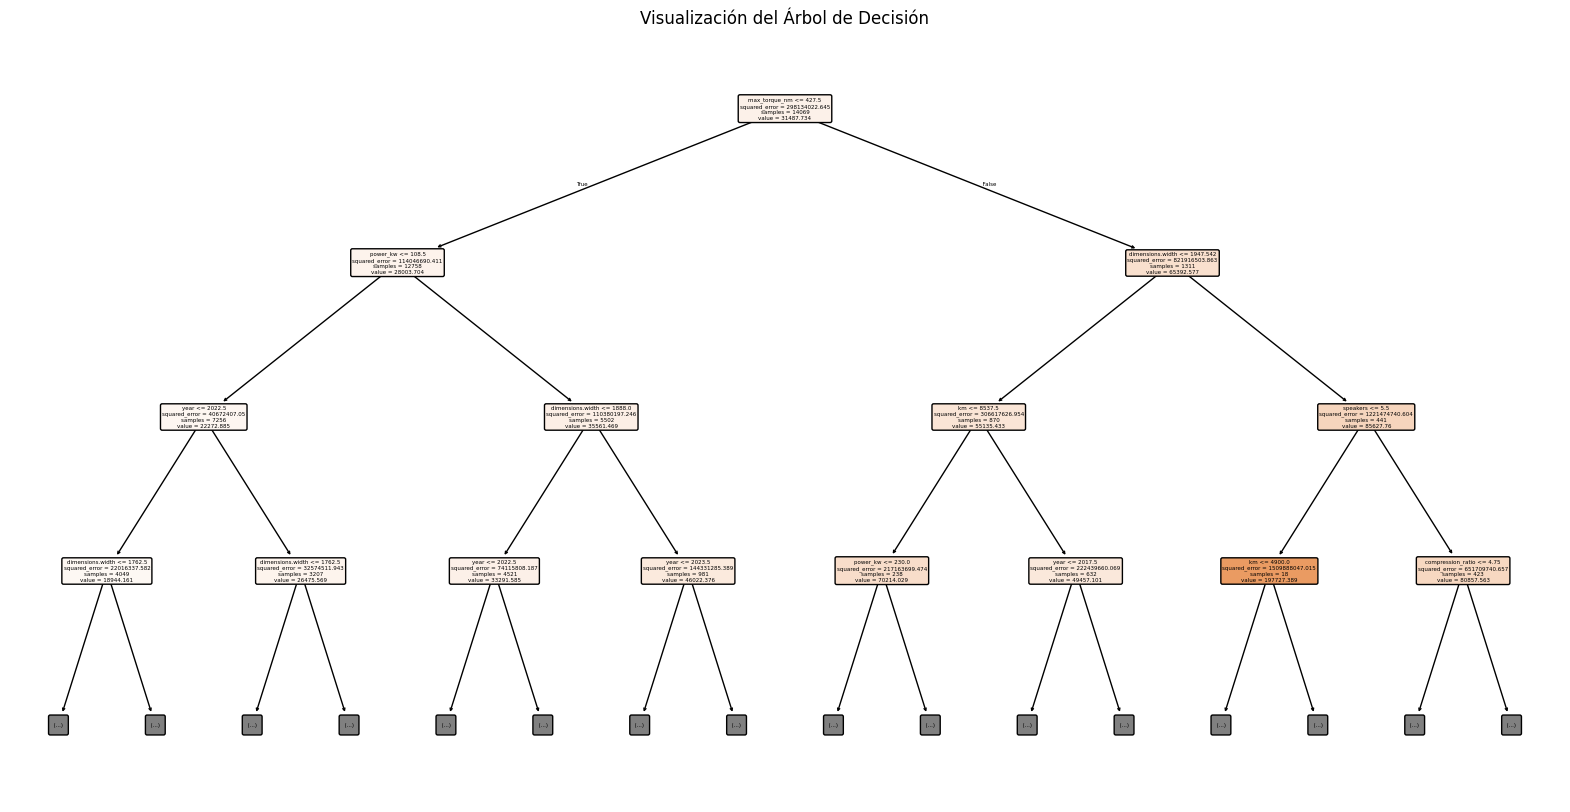

In [21]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Random Forest

In [22]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = RandomForestClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [23]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
idx,,,
88600,Luxury,Luxury,0
85136,Budget,Budget,0
3674,Budget,Budget,0
136840,Luxury,Luxury,0
88035,Premiun,Premiun,0


In [24]:
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7582089552238805 
 Precision: 0.7560836223129507 
 Recall: 0.7582089552238805 
 F1 Score: 0.7564447497810842
Confusion Matrix:
 [[1809    4    1    2   12   48  155    3    0]
 [   5  334    0    6   80    0   19   86    0]
 [   4    0   22    0    0   13    2    0    3]
 [   0    4    0  464    1    0    0   80    0]
 [  32   85    0    4  438    0  133   17    0]
 [  92    0   15    0    1  298    2    2    0]
 [ 220   23    0    3  115    0  741    8    0]
 [   1   83    0   69   18    0    6  464    0]
 [   0    0    0    0    0    1    0    0    2]]


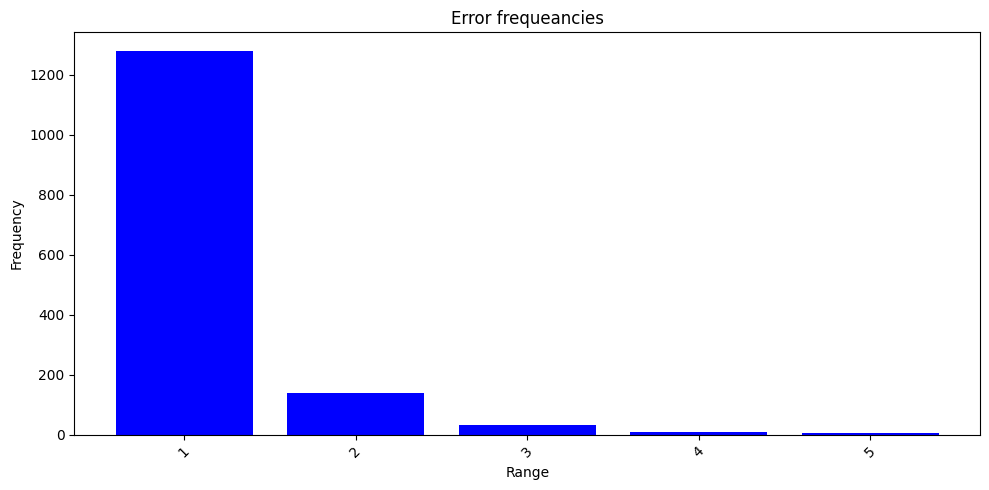

{1: 1277, 2: 139, 3: 31, 4: 7, 5: 4}
Error mean: 1.1632373113854595
Error rate: 24.17910447761194 %
Overall mean: 0.28126036484245437


In [25]:
Evaluator.eval_ordinal_classification (result["diff"])

# Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
import numpy as np
import pandas as pd

# Prepare the data
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Create the Naive Bayes model
nb_model = GaussianNB() # You can try other Naive Bayes models such as ComplementNB, BernoulliNB, BinomialNB but Gaussian gives the best results in this case

# Train the model
nb_model.fit(X_train, Y_train)

# Predict the labels of the test set
Y_pred = nb_model.predict(X_test)

# Create a results DataFrame to compare predictions
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)

# Show the first few rows of the results
result.head()


,Real_Categorie,Prediction,diff
idx,,,
88600,Luxury,Premiun,1
85136,Budget,Middle high range,2
3674,Budget,Middle low range,1
136840,Luxury,Luxury,0
88035,Premiun,Luxury,1


In [27]:
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.417910447761194 
 Precision: 0.46838332494583024 
 Recall: 0.417910447761194 
 F1 Score: 0.42392137779435607
Confusion Matrix:
 [[914  66  23  26 168 114 538 109  76]
 [ 12 168   1 125  78   0  18 128   0]
 [  5   0   4   1   0  27   0   0   7]
 [  5  19   0 465  10   0   1  49   0]
 [ 38 174   4  90 232   0  51 120   0]
 [ 90   1   6   4   1 291   4   1  12]
 [190 182  10  75 221   0 281 148   3]
 [  4  87   3 344  37   0   3 163   0]
 [  0   0   0   0   0   1   0   0   2]]


# Agorithms evaluation

In [28]:
hybird_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = hybird_cars[["price", "price_categ"]]
hybird_cars.drop(columns=["price", "price_categ"], inplace=True)


numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    hybird_cars[[column]] = scaler.fit_transform(hybird_cars[[column]])
    encoders_and_scalers[column] = scaler 

hybrid_cars_encoded = pd.get_dummies(hybird_cars, columns=categorical_column_names)

## Classification

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hybrid_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [30]:
from sklearn.model_selection import cross_val_score


def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    else:  Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)
    cv_scores = cross_val_score(classifier, X_test, y_test, cv=5, scoring='accuracy')
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")




### CART

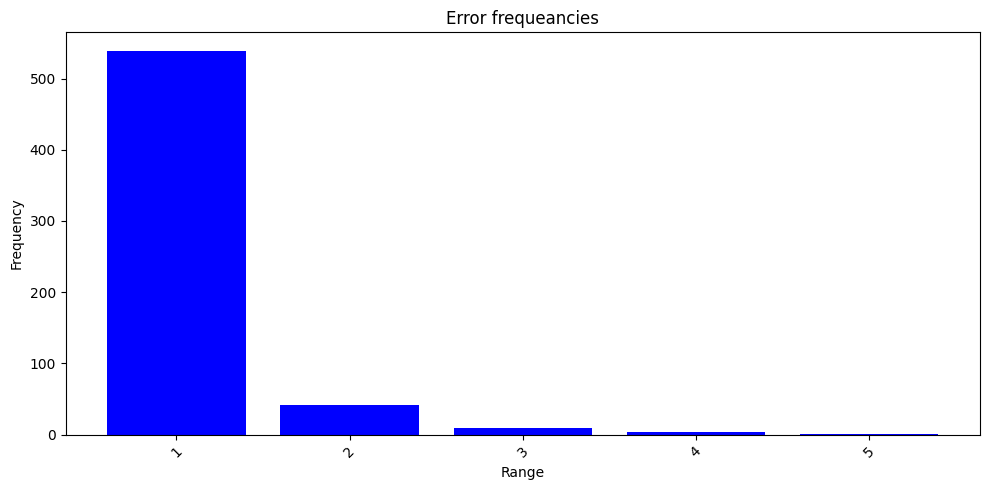

{1: 538, 2: 41, 3: 9, 4: 3, 5: 1}
Error mean: 1.1216216216216217
Error rate: 9.817578772802653 %
Overall mean: 0.007296849087893864
Accuracy: 0.8084577114427861 
 Precision: 0.8079462192885104 
 Recall: 0.8084577114427861 
 F1 Score: 0.8078859773336478
Confusion Matrix:
 [[ 360    0   13    0    0   42    3    0    3]
 [   1  356    0    4  104    1   11   67    0]
 [  14    0   27    0    1    3    0    0    0]
 [   0    0    0  510    2    1    2   43    0]
 [   0   84    0    0  484   14  108    7    0]
 [  35    1    2    0   12 1807  118    0    0]
 [   0   17    1    0  118  159  841    2    0]
 [   0   76    0   68   11    0    5  489    0]
 [   0    0    1    0    0    1    0    0    1]]


/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


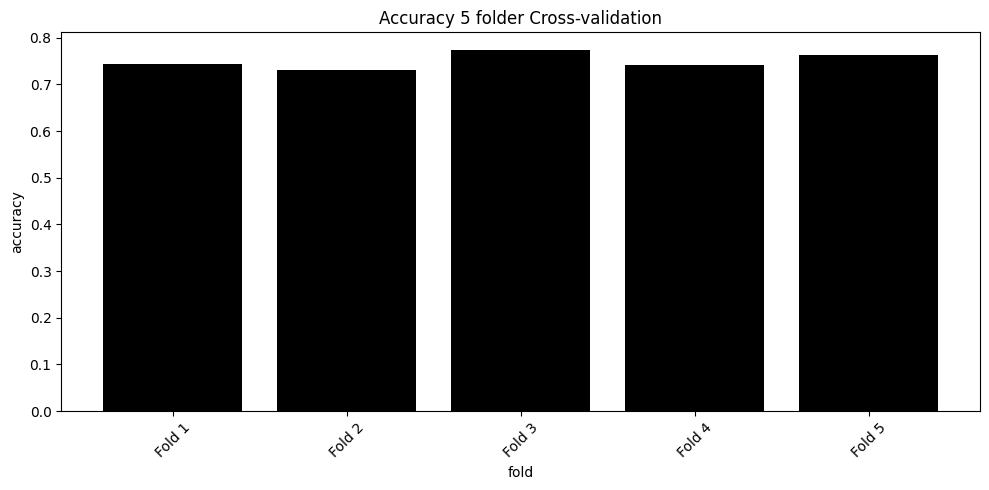

In [31]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest

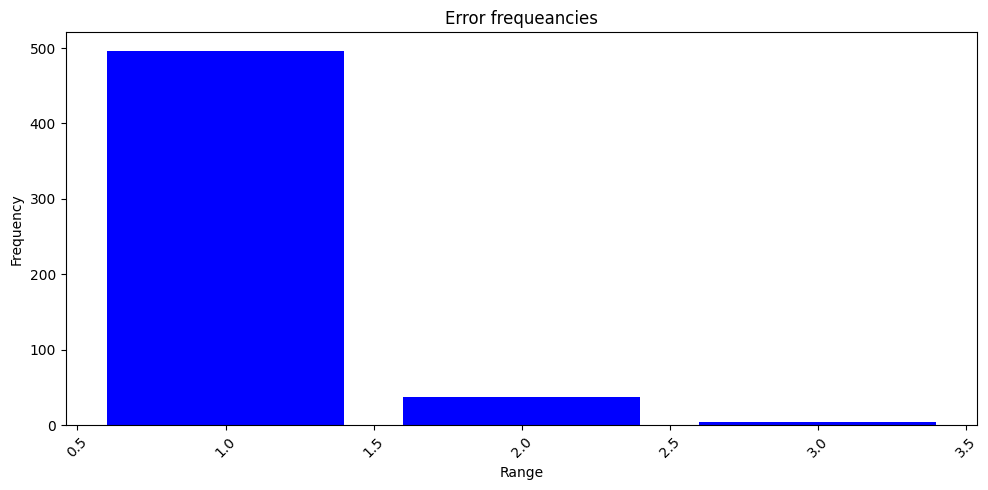

{1: 496, 2: 38, 3: 4}
Error mean: 1.0855018587360594
Error rate: 8.922056384742952 %
Overall mean: 0.0009950248756218905
Accuracy: 0.824709784411277 
 Precision: 0.8227539709049025 
 Recall: 0.824709784411277 
 F1 Score: 0.8232904404829818
Confusion Matrix:
 [[ 351    0   11    0    0   57    1    1    0]
 [   0  373    0    4   85    2   11   69    0]
 [  21    0   21    1    0    2    0    0    0]
 [   0    3    0  515    1    0    0   39    0]
 [   0   69    0    0  493   13  114    8    0]
 [  25    0    1    0    6 1835  108    0    0]
 [   1   14    0    2   98  155  865    3    0]
 [   0   67    0   53    9    0    1  519    0]
 [   0    0    1    0    0    1    0    0    1]]


/home/lingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [32]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM

In [ ]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

In [ ]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    hybrid_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [ ]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

## Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hybrid_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [ ]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(hybrid_cars_encoded.columns), regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

### Cart

In [ ]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### RandomForest

In [ ]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

In [ ]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

### Multivariable regression

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

In [ ]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

In [ ]:
Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(hybrid_cars_encoded.columns), regressor_name="Lineal Regression")
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
cv_scores = -cross_val_score(linear_regressor, X_test, y_test, cv=5, scoring=mape_scorer)
Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

In [ ]:
result

 ### ANN Regression

In [ ]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()

In [ ]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

In [ ]:
Evaluator.save("hybrid")

In [33]:
master = MasterGenerator(X=hybrid_cars_encoded, y_categ=target["price_categ"], y_numeric=target["price"], n_tries=128, CUML=True, name="HP_hybrid")

In [ ]:
master._classification_generate()

[I 2024-12-22 10:27:49,717] Trial 4 finished with value: 0.33034825870646767 and parameters: {'C': 5.4605464378928295, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 3 with value: 0.8126865671641791.
[I 2024-12-22 10:41:26,224] Trial 5 finished with value: 0.33034825870646767 and parameters: {'C': 31.340133195804487, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 3 with value: 0.8126865671641791.
[I 2024-12-22 10:47:23,541] Trial 6 finished with value: 0.6450248756218906 and parameters: {'C': 0.43215336769386964, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.8126865671641791.
[I 2024-12-22 10:51:28,371] Trial 7 finished with value: 0.631592039800995 and parameters: {'C': 5.463105145181689, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 3 with value: 0.8126865671641791.
[I 2024-12-22 10:58:41,433] Trial 8 finished with value: 0.6990049751243781 and parameters: {'C': 9.85638728392567, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 3 with value: 